In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from scipy.signal import lfilter
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import  plotly.graph_objects as go
import pandas as pd
from src.passband_modulations  import bpsk_mod,bpsk_demod
from src.channels import awgn
from src.essentials import plotWelchPSD 
from scipy.special import erfc

In [10]:
def DEBPSK_performance():

    N = 10000 # Number of symbols to transmit
    EbN0dB = np.arange(-4,11,2) # Eb/N0 range in dB for simulation
    L = 16 # Oversampling factor, L = Tb/Ts (Tb = bit period, Ts = sampling period)
    # If a carrier is used, use L = Fs/Fc, where Fs >> 2*Fc
    Fc = 800 # Carrier frequency
    Fs = L*Fc # Sampling frequency
    SER = np.zeros(len(EbN0dB)) # For SER values for each EbN0

    ak = np.random.randint(2, size = N) # Uniform random symbols from 0s and 1s
    bk = lfilter([1.0], [1.0,-1.0], ak) # IIR filter for differential encoding
    bk = bk % 2 # XOR operation is equivalent to modulo-2

    [s_bb,t] = bpsk_mod(bk,L) # BPSK modulation (waveform) - baseband
    s = s_bb*np.cos(2*np.pi*Fc*t/Fs) # DEBPSK with carrier

    for i, EbN0 in enumerate(EbN0dB):

        # Compute and add AWGN noise
        r = awgn(s,EbN0,L) # Refer to Chapter section 4.1

        phaseAmbiguity = np.pi # 180 degree phase ambiguity of Costas loop
        r_bb = r*np.cos(2*np.pi*Fc*t/Fs + phaseAmbiguity) # Recovered signal
        b_hat = bpsk_demod(r_bb, L) # Baseband correlation type demodulator
        a_hat = lfilter([1.0,1.0], [1.0], b_hat) # FIR for differential decoding
        a_hat = a_hat % 2 # Binary messages, therefor modulo-2
        SER[i] = np.sum(ak != a_hat)/N # Symbol error rate computation

    #------Theoretical Bit/Symbol Error Rates------
    EbN0lins = 10**(EbN0dB/10) # Converting dB values to linear scale
    theorySER_DPSK = erfc(np.sqrt(EbN0lins))*(1-.5*erfc(np.sqrt(EbN0lins)))
    theorySER_BPSK = .5*erfc(np.sqrt(EbN0lins))

    #------Plots------
    plt.figure(0)
    plt.semilogy(EbN0dB,SER,'k*',label='Coherent DEBPSK(sim)')
    plt.semilogy(EbN0dB,theorySER_DPSK,'r-',label='Coherent DEBPSK(theory)')
    plt.semilogy(EbN0dB,theorySER_BPSK,'b-',label='Conventional BPSK')
    plt.xlabel('$E_b/N_0$ (dB)')
    plt.ylabel('Probability of Bit Error - $P_b$')
    plt.title('Probability of Bit Error for DEBPSK and BPSK over AWGN')
    plt.legend()
    #plt.savefig('Ch2_images/DEBPSK_performance.png')

<h1 style="text-align: center;"> Transmissão DBPSK </h1>

<h3 style="text-align: center;">Disciplina: Comunicações Digitais para Engenaharia</h3>


<p style="text-align: center;">Prof. Daniel C. Araújo</p>

# Modulador 

> Uso de um codificador diferencial  

$$
b[k] = b[k-1] \oplus  a[k]
$$

> Neste caso, a fase é configurada pela diferença de fase entre dois símbolos consecutivos.

  * O objetivo é resolver a ambiguidade de fase que podem ocorrer devido a mecanismos de sincronização.

<img src="Figs/mod_digi/dbpsk_tx.png" alt="isolated"/>

# Demodulador

<img src="Figs/mod_digi/dbpsk_rx.png" alt="isolated"/>

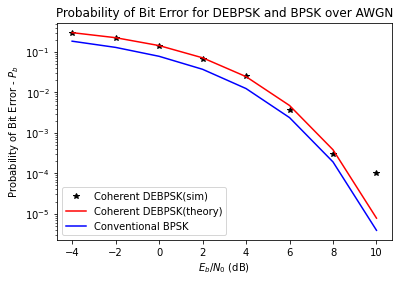

In [13]:
desemempenho_dbpsk = DEBPSK_performance()